# Scientometrics based on web of science in search of 'data literacy'

In [1]:
import sys
sys.executable

'/Users/heavenly/opt/anaconda3/envs/mqed/bin/python'

<h2>1. Login with selenium and access the web site directly</h2>

### Read bibtex files and transformation of them into dataframe

In [ ]:
!pip install bibtexparser

In [60]:
import bibtexparser
import pandas as pd

df = pd.DataFrame()

download_path = '/Users/heavenly/Downloads'

file_name = 'savedrecs.bib'
file_path = os.path.join(download_path, file_name)
print(file_path)
with open(file_path) as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

df = pd.DataFrame(bib_database.entries)
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

/Users/heavenly/Downloads/savedrecs.bib
/Users/heavenly/Downloads/savedrecs (1).bib
/Users/heavenly/Downloads/savedrecs (2).bib
/Users/heavenly/Downloads/savedrecs (3).bib
/Users/heavenly/Downloads/savedrecs (4).bib
/Users/heavenly/Downloads/savedrecs (5).bib
/Users/heavenly/Downloads/savedrecs (6).bib
/Users/heavenly/Downloads/savedrecs (7).bib
/Users/heavenly/Downloads/savedrecs (8).bib
/Users/heavenly/Downloads/savedrecs (9).bib
/Users/heavenly/Downloads/savedrecs (10).bib
/Users/heavenly/Downloads/savedrecs (11).bib
/Users/heavenly/Downloads/savedrecs (12).bib
/Users/heavenly/Downloads/savedrecs (13).bib
/Users/heavenly/Downloads/savedrecs (14).bib
/Users/heavenly/Downloads/savedrecs (15).bib
/Users/heavenly/Downloads/savedrecs (16).bib
/Users/heavenly/Downloads/savedrecs (17).bib


In [65]:
df.to_excel('Data/dl_raw.xlsx')

<h2>2. Refinement of data</h2>

In [66]:
import pandas as pd

In [68]:
df = pd.read_excel('Data/dl_raw.xlsx', index_col=0)

In [69]:
df = df[['da', 'web-of-science-index', 'usage-count-since-2013', 'usage-count-last-180-days', 'times-cited',
       'number-of-cited-references', 'cited-references', 'affiliations',
       'web-of-science-categories', 'research-areas', 'keywords-plus',
       'keywords', 'doi', 'affiliation', 'type', 'address',
       'abstract', 'organization', 'year',
       'booktitle', 'title', 'author', 'author-email', 'journal-iso', 'month', 'journal',
       'funding-text', 'funding-acknowledgement']]

In [70]:
df

da                               web-of-science-index  \
0     2023-11-17             Emerging Sources Citation Index (ESCI)   
1     2023-11-17  Conference Proceedings Citation Index - Scienc...   
2     2023-11-17               Social Science Citation Index (SSCI)   
3     2023-11-17               Social Science Citation Index (SSCI)   
4     2023-11-17  Conference Proceedings Citation Index - Scienc...   
...          ...                                                ...   
8592  2023-11-17  Book Citation Index – Social Sciences & Humani...   
8593  2023-11-17               Social Science Citation Index (SSCI)   
8594  2023-11-17  Science Citation Index Expanded (SCI-EXPANDED)...   
8595  2023-11-17               Social Science Citation Index (SSCI)   
8596  2023-11-17               Social Science Citation Index (SSCI)   

      usage-count-since-2013  usage-count-last-180-days  times-cited  \
0                         44                          3            2   
1                         48                          9            3   
2                         93                         25            5   
3                        120                          9           38   
4                          4                          0            2   
...                      ...                        ...          ...   
8592                       8                          0           12   
8593                      27                          1           17   
8594                       3                          0            2   
8595                      21                          1            5   
8596                      75                          1           86   

      number-of-cited-references  \
0                             48   
1                             24   
2                             75   
3                             52   
4                             17   
...                          ...   
8592                          41   
8593                          58   
8594                          64   
8595                          51   
8596                          87   

                                       cited-references  \
0     Al Nuaimi E, 2015, J INTERNET SERV APPL, V6, D...   
1     Ahmad I., 2018, KEMENTERIAN RISET TE, P1.\n{[}...   
2     Abrami PC, 2008, REV EDUC RES, V78, P1102, DOI...   
3     ACAR G, 2014, C COMP COMM SEC SCOT.\n{[}Anonym...   
4     Agrawal A, 2014, ELEC COMP C, P2014, DOI 10.11...   
...                                                 ...   
8592  {[}Anonymous], TOPICS LANGUAGE DISO.\n{[}Anony...   
8593  {[}Anonymous], 2010, HEAD START CHILD DEV.\n{[...   
8594  Abrams Steven A, 2020, J Pediatr X, V4, P10004...   
8595  Ahmed Y, 2014, J EDUC PSYCHOL, V106, P419, DOI...   
8596  Adachi M., 2012, OXFORD HDB MUSIC ED, P229.\nA...   

                                           affiliations  \
0     Swiss Federal Institutes of Technology Domain;...   
1                         Universitas Negeri Yogyakarta   
2                               Simon Fraser University   
3                                     Deakin University   
4     University of Warsaw; Wroclaw University of Sc...   
...                                                 ...   
8592  University of Houston System; University of Ho...   
8593  University of Kansas; University of Missouri S...   
8594  Washington State University; University of Mai...   
8595  Boston College; University of Rochester; Brown...   
8596  University of Queensland; Queensland Universit...   

                              web-of-science-categories  \
0                     Education \& Educational Research   
1     Education \& Educational Research; Education, ...   
2                     Education \& Educational Research   
3                     Education \& Educational Research   
4     Computer Science, Interdisciplinary Applicatio...   
...                                                 ...   
8592  Education, Special; Ethnic

### Keyword generation using Transformers

In [71]:
from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy
import numpy as np

# Define keyphrase extraction pipeline
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, all_outputs):
        results = super().postprocess(
            all_outputs=all_outputs,
            aggregation_strategy=AggregationStrategy.FIRST,
        )
        return np.unique([result.get("word").strip() for result in results])
    
model_name = "ml6team/keyphrase-extraction-distilbert-inspec"
extractor = KeyphraseExtractionPipeline(model=model_name)

In [72]:
%%time

import numpy as np

for i in range(len(df)):
    if df.loc[i, 'keywords'] is np.nan:
        text = df.loc[i, 'abstract']
        if text is np.nan:
            continue
            
        text = text.replace('\n', ' ').strip()

        if text is not np.nan:
            keys = extractor(text)

            if (len(keys) > 0):
                df.loc[i, 'keywords'] = ';'.join(keys)

#다시 저장하기
df['keywords'] = df['keywords'].str.lower()
df['keywords'] = df['keywords'].str.replace('\n', '')

CPU times: user 36min 11s, sys: 53.9 s, total: 37min 5s
Wall time: 6min 29s


In [76]:
import matplotlib.pyplot as plt
import numpy as np

yearly_counts = df['year'].value_counts().reset_index()
yearly_counts.columns = ['Year', 'Count']
yearly_counts = yearly_counts.sort_values(by='Year')

min_year = yearly_counts['Year'].min()
max_year = yearly_counts['Year'].max()
year_range = range(min_year, max_year + 1)

# 비어 있는 연도를 찾아서 빈도를 0으로 설정
missing_years = set(year_range) - set(yearly_counts['Year'])
missing_data = [{'Year': year, 'Count': 0} for year in missing_years]
yearly_counts = pd.concat([yearly_counts, pd.DataFrame(missing_data)], ignore_index=True)

# 연도로 데이터프레임 정렬
yearly_counts = yearly_counts.sort_values(by='Year')

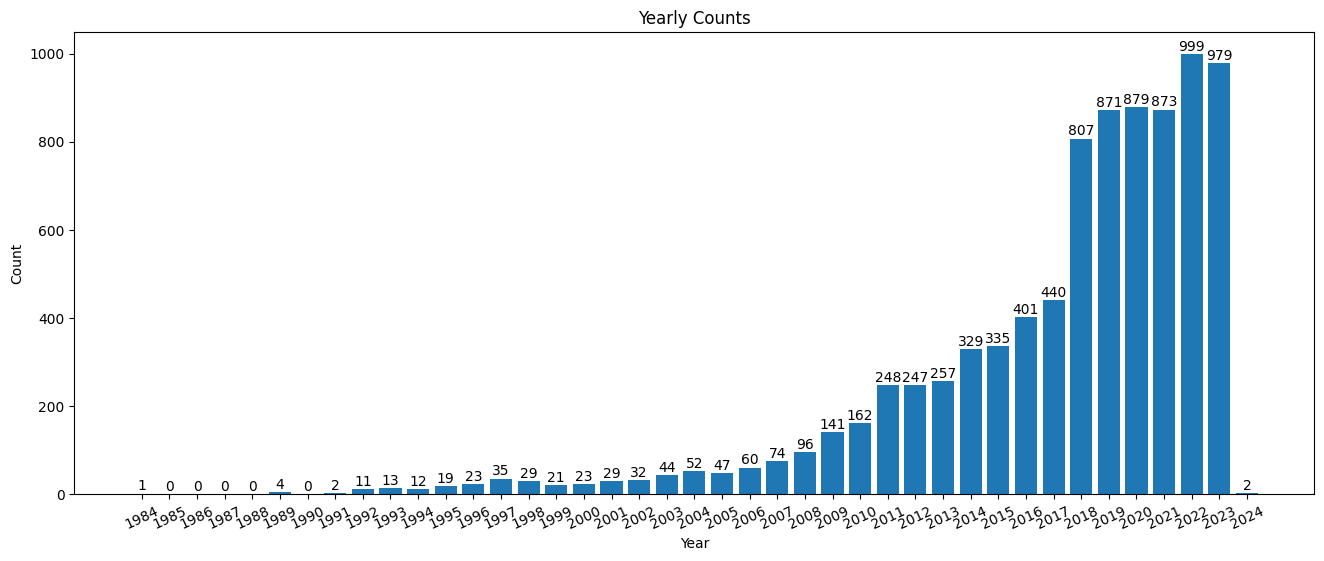

In [77]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.bar(yearly_counts['Year'], yearly_counts['Count'])
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Yearly Counts')

# x 축의 눈금 설정 (매년)
x_ticks = np.arange(yearly_counts['Year'].min(), yearly_counts['Year'].max() + 1)
ax.set_xticks(x_ticks)

# x 축 레이블 기울이기
ax.set_xticklabels(yearly_counts['Year'], rotation=25)

# 막대 위에 숫자 표시
for i, count in enumerate(yearly_counts['Count']):
    ax.text(yearly_counts['Year'].iloc[i], count + 1, str(count), ha='center', va='bottom')

plt.show()

In [78]:
# 데이터프레임 생성 (실제 데이터프레임 사용할 경우 생략)
def get_top_keywords(df, start_year, end_year, top_n=10):
    freq_dict = {}
    # 특정 연도와 카테고리에 해당하는 데이터 필터링
    filtered_df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    count = len(filtered_df)
    
    for item in filtered_df['keywords']:
        if item is not np.nan:
            keys = item.split(';')

            for key in keys:
                key = key.strip()
                if key not in freq_dict:
                    freq_dict[key] = 1
                else:
                    freq_dict[key] += 1
                
    # 빈도가 높은 순으로 정렬
    sorted_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))

    if top_n == -1:
        return count, sorted_dict, sum(freq_dict.values()), list(sorted_dict.items())
    else:
        return count, sorted_dict, sum(freq_dict.values()), list(sorted_dict.items())[:top_n]

In [80]:
years = [1989, 1994, 1999, 2004, 2009, 2014, 2019]

for year in years:
    year_end = year + 4 if year == 1998 else year + 4
    print(f'from {year} to {year_end}\n')
    _, dict1, count, top_keywords = get_top_keywords(df, year, year_end, top_n=20)

    for key, val in top_keywords:
        print(f"{key}: {val}")

    print('\n')

from 1989 to 1993

children: 6
literacy development: 4
students: 4
emergent literacy: 2
literacy learning: 2
drawing: 2
schooling: 2
computer literacy: 2
phonemic awareness: 2
girls: 2
indexes of cognitive change: 1
orthography: 1
phoneme-grapheme relations: 1
reading-writing relations: 1
transitionalknowledge: 1
transitional mechanisms: 1
bilingual esl program: 1
cambodia: 1
first language literacy: 1
fluent speakers: 1


from 1994 to 1998

children: 24
literacy: 21
students: 17
teachers: 12
kindergarten: 7
literacy learning: 6
elsevier science: 6
writing: 6
literacy development: 5
literacy events: 5
literacy practices: 5
reading: 5
computer literacy: 5
age: 4
literature: 4
language: 4
adult literacy: 3
national adult literacy survey: 3
feedback: 3
history: 3


from 1999 to 2003

literacy: 25
children: 23
teachers: 17
students: 14
literacy instruction: 10
literacy learning: 8
reading: 8
literacy practices: 6
dyslexia: 5
adults: 5
literacy teaching: 5
gender: 5
school: 5
scientific lit

In [81]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = []

for item in df.keywords:
    if (item is not np.nan) and (type(item) is not float):
        keys = item.split(';')
        if len(keys) >= 1: data.append(keys)

# 빈도 계산
node_freq = {}
for sublist in data:
    for node in sublist:
        node = node.strip()
        if node in node_freq:
            node_freq[node] += 1
        else:
            node_freq[node] = 1

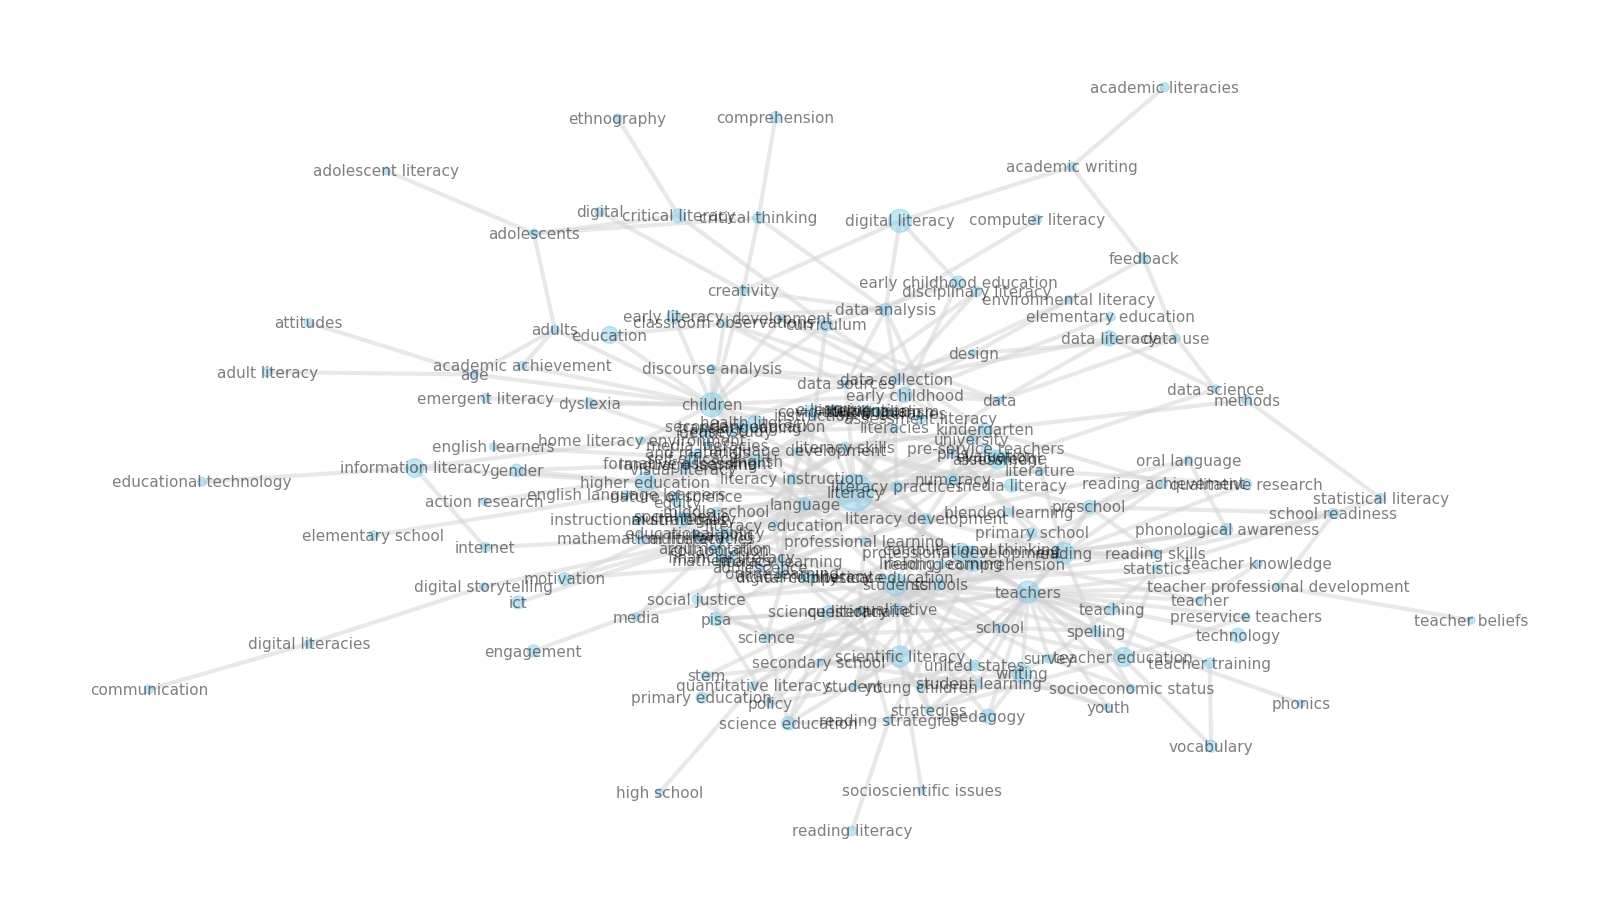

In [86]:
plt.figure(figsize=(16, 9))

min_val = 30
k = 1
enz = 1

# 그래프 생성
G = nx.Graph()

# 노드 추가 및 크기 설정
for node, freq in node_freq.items():
    if freq >= min_val:
        G.add_node(node, size=freq * enz)  # 노드 크기 설정

# 엣지 추가 (자기 자신에게 연결된 엣지는 제외)
for sublist in data:
    for i in range(len(sublist) - 1):
        if sublist[i] in G.nodes and sublist[i + 1] in G.nodes and sublist[i] != sublist[i + 1]:
            G.add_edge(sublist[i], sublist[i + 1])

# 스프링 레이아웃 계산
pos = nx.spring_layout(G, k=k / max(node_freq.values()))  # 빈도에 따라 스프링 강도를 조절
pos = nx.kamada_kawai_layout(G, scale=100.0)

# 그래프 시각화 (엣지 투명도 추가)
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', cmap='Blues',
        font_size=11, font_color='black', edge_color='lightgray', width=3.0, style='solid', 
        alpha=0.5)  # 엣지 투명도 설정

plt.show()

In [90]:
df.sort_values(by='times-cited', ascending=False).head(20)[['title', 'keywords', 'times-cited']]

title  \
6319  Establishing the norms of scientific argumenta...   
7665  Enhancing the quality of argumentation in scho...   
1177  Teaching disciplinary literacy to adolescents:...   
2512  Working toward third space in content area lit...   
8422  Phases of inquiry-based learning: Definitions ...   
7222  What ``ideas-about-science{''} should be taugh...   
4331  Added value of dialogic parent-child book read...   
5790  Development and psychometric evaluation of the...   
3775  Translating Learning into Numbers: A Generic F...   
5465  Barriers and solutions to online learning in m...   
8036   Reinterpreting the development of reading skills   
5021  Exploring the online reading comprehension str...   
2076     Can we teach digital natives digital literacy?   
6994  Learning to teach argumentation: Research and ...   
2394  ``Catalyst data': perverse systemic effects of...   
2078  Translanguaging and transnational literacies i...   
8170  <i>We Be Burnin</i>'! Agency, Identity, and Sc...   
6102  Testing a Conception of How School Leadership ...   
5234  Transformational school leadership for large-s...   
5348               Is Kindergarten the New First Grade?   

                                               keywords  times-cited  
6319  classroom;dialogic argument;science;science cl...         1087  
7665  argumentation;junior high schools;science teac...          705  
1177  adolescent readers;adolescents;advanced discip...          696  
2512  content learning;funds;literacy;literacy teach...          627  
8422  inquiry-based learning; inquiry cycle; inquiry...          574  
7222  consensus;expert science teachers;internationa...          561  
4331  book reading;children;dialogic reading;dialogi...          544  
5790  clinical trials;domain of interest;hiv;interna...          450  
3775  learning analytics; framework; educational dat...          391  
5465  e-learning; online learning; medical education...          380  
8036  causal misinterpretations;constrained skills;d...          368  
5021  implications;inferential reasoning strategies;...          360  
2076  media in education; postsecondary education; t...          356  
6994  argument pattern;argument pattern analysis;arg...          323  
2394  catalyst data; accountability; high stakes tes...          320  
2078  additive bilingualism; biliteracy; bilingual e...          314  
8170  community science;energy use;green energy tech...          311  
6102  leadership; mediating variables; academic pres...          303  
5234  classroom practices;leadership;literacy;numera...          298  
5348  kindergarten; early childhood education; acade...          269

In [93]:
area_dict = {}
count = len(df)

for item in df['research-areas']:
    if item is not np.nan:
        keys = item.split(';')

        for key in keys:
            key = key.strip()
            if key not in area_dict:
                area_dict[key] = 1
            else:
                area_dict[key] += 1

# 빈도가 높은 순으로 정렬
area_dict = sorted(area_dict.items(), key=lambda item: item[1], reverse=True)

In [94]:
area_dict[:20]

[('Education \\& Educational Research', 8559),
 ('Psychology', 930),
 ('Linguistics', 717),
 ('Computer Science', 333),
 ('Rehabilitation', 236),
 ('Engineering', 120),
 ('Public, Environmental \\& Occupational\nHealth', 118),
 ('Social Sciences - Other Topics', 80),
 ('Business \\& Economics', 74),
 ('Physics', 57),
 ('Health Care Sciences \\& Services', 49),
 ('Public, Environmental \\&\nOccupational Health', 48),
 ('Environmental Sciences \\& Ecology', 47),
 ('Oncology', 47),
 ('Communication', 39),
 ('Education \\& Educational\nResearch', 38),
 ('Sociology', 35),
 ('Nursing', 34),
 ('Information Science\n\\& Library Science', 33),
 ('Life Sciences \\& Biomedicine - Other Topics', 33)]

In [95]:
df.to_excel('Data/dl_upd.xlsx')

## visualize clustering by using Plot.ly

In [2]:
import pandas as pd

In [3]:
# abstract가 없는 경우는 제외하도록 한다.
df = pd.read_excel('Data/dl_upd.xlsx', index_col=0)
print(df.shape)
df = df.dropna(subset=['abstract'])
print(df.shape)

(8597, 28)
(8564, 28)


In [4]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [36]:
%%time 

# It takes much more time than you expected
document_embeddings = sbert_model.encode(list(df['abstract']))
document_embeddings.shape

CPU times: user 1h 25min 42s, sys: 4min, total: 1h 29min 43s
Wall time: 16min 16s


(8564, 384)

In [37]:
import umap

X_embedded = umap.UMAP(n_components=2, n_epochs=2000, learning_rate=0.001).fit_transform(document_embeddings)

df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})

In [38]:
import joblib

joblib.dump(document_embeddings, 'Data/doc_embed.pkl')

['Data/doc_embed.pkl']

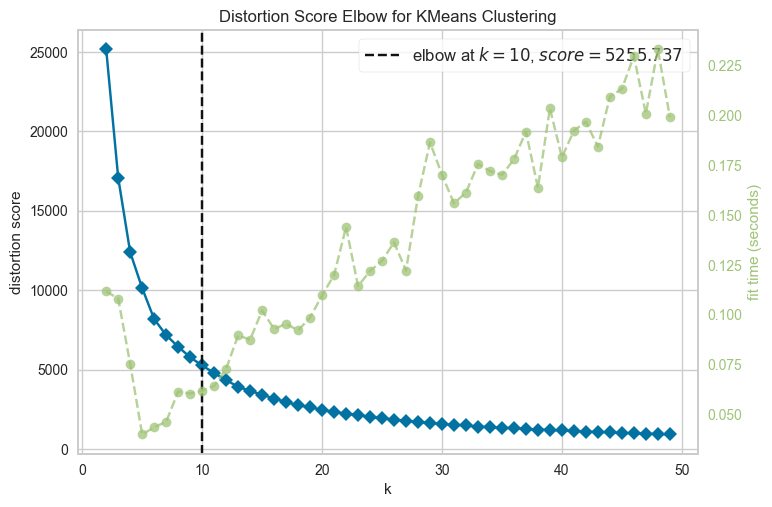

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action='ignore')

model2 = KMeans()
# k is range of number of clusters
visualizer = KElbowVisualizer(model2, k=(2,50), timings= True)
visualizer.fit(df_embeddings[['x', 'y']])
visualizer.show()

In [40]:
kmeans = KMeans(n_clusters=visualizer.elbow_value_).fit(document_embeddings)

In [41]:
cluster_labels = [f"Cluster {i+1}" for i in range(visualizer.elbow_value_)]

In [42]:
df_embeddings['cluster'] = kmeans.labels_

labels = []
for item in df_embeddings.cluster:
    labels.append(cluster_labels[item])
    
df_embeddings['label'] = labels
df_embeddings['color'] = kmeans.labels_

In [43]:
df_embeddings['cluster'].value_counts()

1    1134
8    1064
9    1015
4     934
2     928
7     785
3     783
6     739
5     650
0     532
Name: cluster, dtype: int64

In [44]:
df_embeddings.cluster += 1

In [46]:
import joblib

joblib.dump(df_embeddings, 'Data/df_embed.pkl')

['Data/df_embed.pkl']

In [45]:
import plotly.express as px

fig = px.scatter(df_embeddings, x='x', y='y', hover_data=['cluster'], title = 'Embedding Visualization',
                 color='label')
                 #color=colors, color_discrete_sequence=colors)
fig.update_layout(width=960, height=800, legend_title='Cluster')
fig.show()

In [47]:
df.reset_index(drop=True, inplace=True)

In [48]:
df['cluster'] = df_embeddings['cluster']
df['cluster'] = df['cluster'].astype(int)

In [49]:
df.cluster.value_counts()

2     1134
9     1064
10    1015
5      934
3      928
8      785
4      783
7      739
6      650
1      532
Name: cluster, dtype: int64

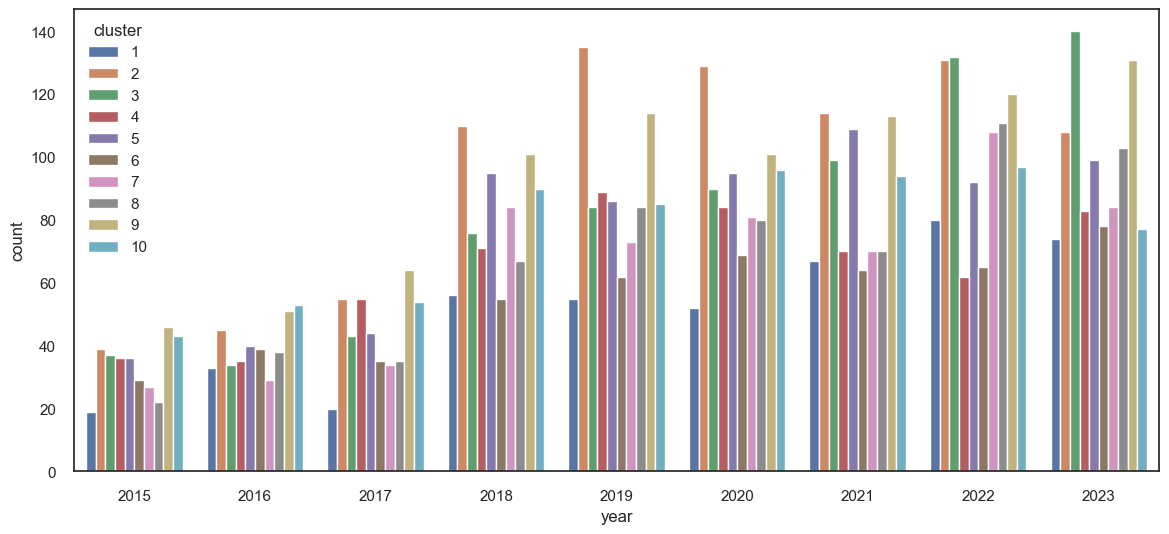

In [59]:
# For the last ten years
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='white')
df_per = df[(df['year'] >= 2015) & (df['year'] <= 2023)]

plt.figure(figsize=(14, 6))
sns.countplot(x="year", hue="cluster", data=df_per)
plt.show()

In [51]:
df['add'] = 1

In [52]:
import numpy as np

pivots = df.pivot_table(index='cluster', columns='year', values='add', aggfunc=np.sum)

In [53]:
df.year.unique()

array([2019, 2020, 2022, 2018, 2016, 2017, 2021, 2023, 2015, 2012, 2014,
       2009, 2011, 2010, 2013, 2003, 2005, 1995, 1999, 2007, 1996, 2008,
       2004, 2002, 2006, 1992, 1998, 1997, 2000, 1993, 2001, 1994, 1991,
       2024])

In [54]:
pivots.fillna(0, inplace=True)
pivots = pivots.astype('int')
pivots

year     1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  ...  \
cluster                                                              ...   
1           0     1     0     0     0     0     2     1     0     0  ...   
2           0     2     2     0     3     3     6     5     4     2  ...   
3           0     0     0     1     1     0     3     2     3     5  ...   
4           0     1     0     2     1     0     2     2     2     1  ...   
5           0     2     3     1     4     8     5     8     2     5  ...   
6           0     1     1     2     3     1     1     2     2     2  ...   
7           0     0     1     0     0     2     1     4     1     1  ...   
8           0     0     2     1     0     2     3     1     1     3  ...   
9           1     0     0     1     0     2     2     0     1     1  ...   
10          1     4     4     4     6     5     9     4     4     3  ...   

year     2015  2016  2017  2018  2019  2020  2021  2022  2023  2024  
cluster                                                              
1          19    33    20    56    55    52    67    80    74     0  
2          39    45    55   110   135   129   114   131   108     0  
3          37    34    43    76    84    90    99   132   140     0  
4          36    35    55    71    89    84    70    62    83     0  
5          36    40    44    95    86    95   109    92    99     0  
6          29    39    35    55    62    69    64    65    78     1  
7          27    29    34    84    73    81    70   108    84     0  
8          22    38    35    67    84    80    70   111   103     0  
9          46    51    64   101   114   101   113   120   131     0  
10         43    53    54    90    85    96    94    97    77     1  

[10 rows x 34 columns]

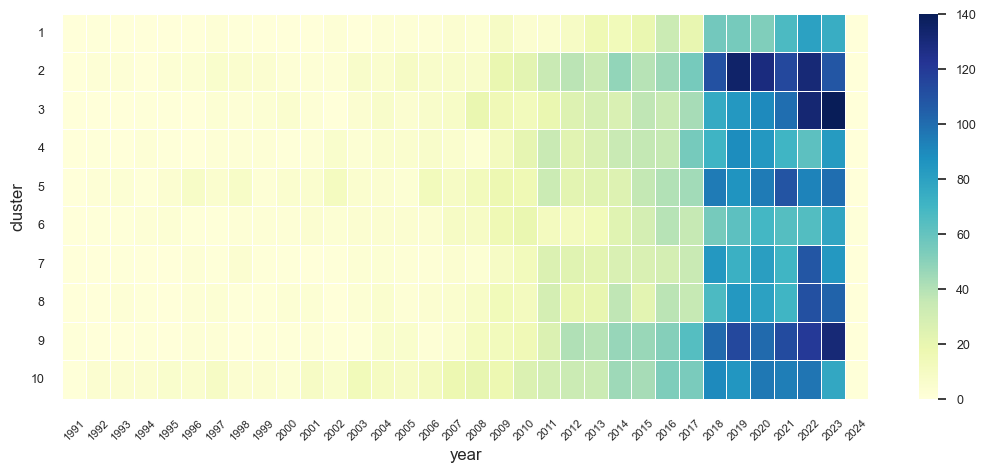

In [55]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(figsize=(13, 5))

g = sns.heatmap(pivots, linewidths=.5, cmap="YlGnBu")

for i, ax in enumerate(g.figure.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

g.figure.show()

<Axes: xlabel='cluster', ylabel='year'>

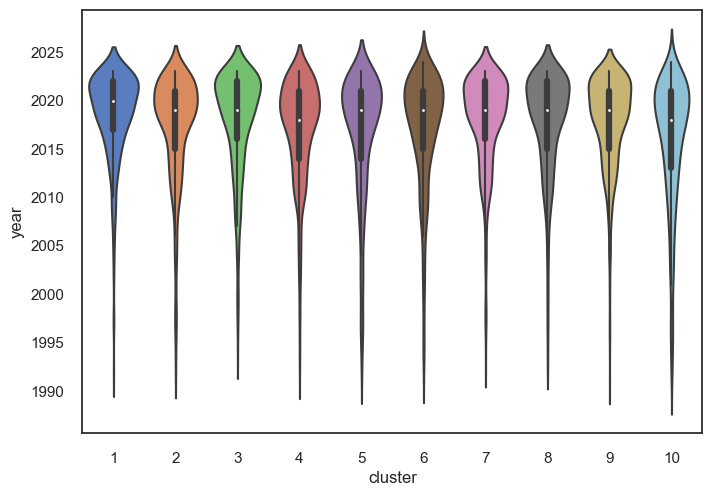

In [60]:
sns.violinplot(x="cluster", y="year", data=df, palette="muted")

In [126]:
pivots.to_excel('Data/dl_pivot.xlsx')

In [127]:
df.to_excel('Data/dl_cluster.xlsx')

# Clustering

In [1]:
import pandas as pd
import joblib

In [4]:
pivot_df = pd.read_excel('Data/dl_pivot.xlsx', index_col=0)

In [5]:
df = pd.read_excel('Data/dl_cluster.xlsx', index_col=0)

In [6]:
df.columns

Index(['da', 'web-of-science-index', 'usage-count-since-2013',
       'usage-count-last-180-days', 'times-cited',
       'number-of-cited-references', 'cited-references', 'affiliations',
       'web-of-science-categories', 'research-areas', 'keywords-plus',
       'keywords', 'doi', 'affiliation', 'type', 'address', 'abstract',
       'organization', 'year', 'booktitle', 'title', 'author', 'author-email',
       'journal-iso', 'month', 'journal', 'funding-text',
       'funding-acknowledgement', 'cluster', 'add'],
      dtype='object')

In [7]:
top50_df = df.sort_values(by='times-cited', ascending=False)[0:50]
top50_df.reset_index(drop=True, inplace=True)

In [8]:
top50_df = top50_df.sort_values(by='times-cited', ascending=True)
top50_df.reset_index(drop=True, inplace=True)

In [9]:
top50_df.tail(20)

da                               web-of-science-index  \
30  2023-11-17               Social Science Citation Index (SSCI)   
31  2023-11-17               Social Science Citation Index (SSCI)   
32  2023-11-17               Social Science Citation Index (SSCI)   
33  2023-11-17               Social Science Citation Index (SSCI)   
34  2023-11-17  Social Science Citation Index (SSCI); Arts &am...   
35  2023-11-17               Social Science Citation Index (SSCI)   
36  2023-11-17  Social Science Citation Index (SSCI); Conferen...   
37  2023-11-17  Science Citation Index Expanded (SCI-EXPANDED)...   
38  2023-11-17               Social Science Citation Index (SSCI)   
39  2023-11-17               Social Science Citation Index (SSCI)   
40  2023-11-17  Science Citation Index Expanded (SCI-EXPANDED)...   
41  2023-11-17               Social Science Citation Index (SSCI)   
42  2023-11-17               Social Science Citation Index (SSCI)   
43  2023-11-17               Social Science Citation Index (SSCI)   
44  2023-11-17  Conference Proceedings Citation Index - Social...   
45  2023-11-17               Social Science Citation Index (SSCI)   
46  2023-11-17               Social Science Citation Index (SSCI)   
47  2023-11-17               Social Science Citation Index (SSCI)   
48  2023-11-17               Social Science Citation Index (SSCI)   
49  2023-11-17               Social Science Citation Index (SSCI)   

    usage-count-since-2013  usage-count-last-180-days  times-cited  \
30                      50                          3          269   
31                     138                          6          298   
32                     126                          4          303   
33                      57                          1          311   
34                     151                          4          314   
35                      79                          3          320   
36                     132                          4          323   
37                     237                         32          356   
38                      73                          7          360   
39                      43                          3          368   
40                     143                         13          380   
41                     252                          5          391   
42                      22                          0          450   
43                     198                          6          544   
44                      98                          4          561   
45                     390                         46          574   
46                      80                          2          627   
47                     106                          2          696   
48                     256                         12          705   
49                     351                          8         1087   

    number-of-cited-references  \
30                          58   
31                          45   
32                          89   
33                          51   
34                          80   
35                          51   
36                          50   
37                          35   
38                         167   
39                          25   
40                          35   
41                          42   
42                          12   
43                          60   
44                          73   
45                          83   
46                          82   
47                          45   
48                          74   
49                          88   

                                     cited-references  \
30  {[}Anonymous], 2006, NEWSWEEK.\n{[}Anonymous],...   
31  {[}Anonymous], 2003, WATCHING LEARNING 3.\n{[}...   
32  ALIGMIELCAREK JM, 2003, DISS ABSTR INT, V64, P...   
33  Ahearn LM, 2001, ANNU REV ANTHROPOL, V30, P109...   
34  {[}Anonymous], 2006, IMAGINING MULTILINGU.\n{[...   
35  Adie L, 2008, J EDUC POLICY, V

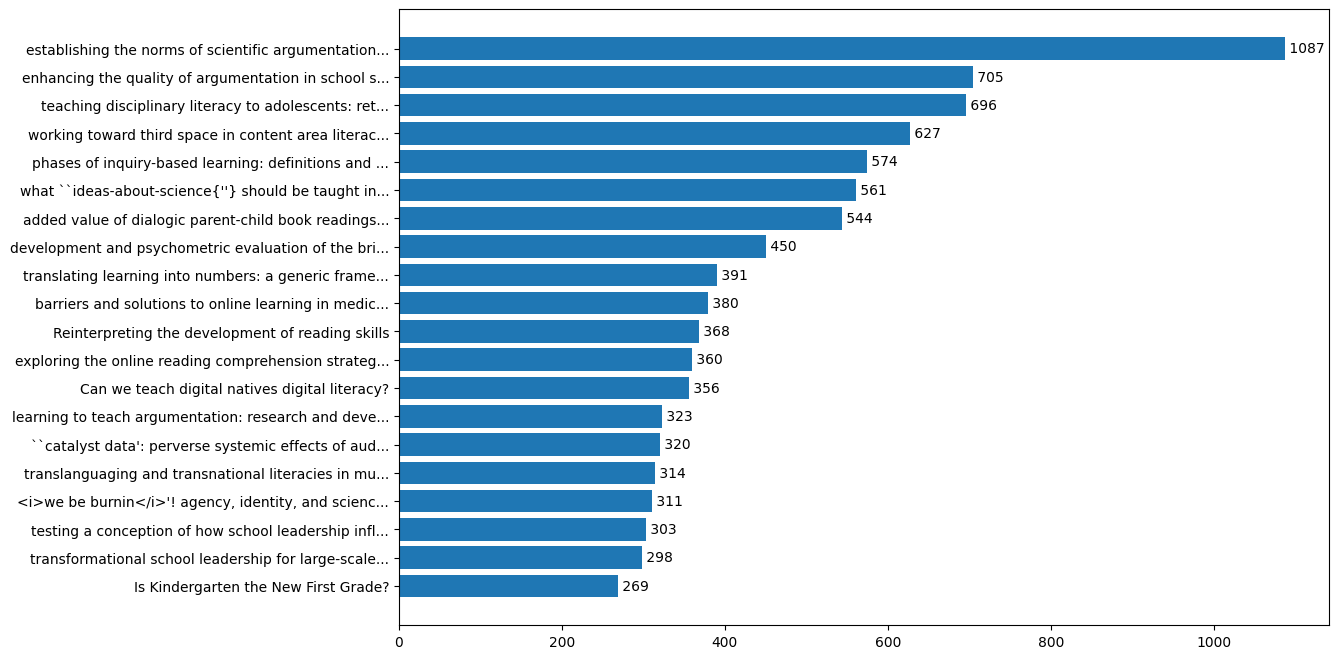

In [10]:
import matplotlib.pyplot as plt

titles = []
cites = []
top20 = top50_df.tail(20)
top20.reset_index(inplace=True, drop=True)

for i, item in enumerate(top20['title']):
    if (len(item) >= 50):
        item = item[:50] + '...'
        item = item.lower()
        
    titles.append(item)
    cites.append(top20.loc[i, 'times-cited'])

plt.figure(figsize=(12, 8))
bars = plt.barh(titles, cites)

# 세로축에 긴 캡션을 설정합니다.
plt.yticks(range(len(titles)), titles)

# 막대의 길이를 조절합니다.
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f' {width}', ha='left', va='center')

plt.show()

# Summarization

In [11]:
df.cluster.value_counts()

8     1077
7     1058
2     1009
3      984
6      916
9      797
4      796
1      731
10     655
5      541
Name: cluster, dtype: int64

In [12]:
from dotenv import load_dotenv
import openai
import os

load_dotenv()

# openai API 키 인증
openai.api_key = os.getenv('OPENAI_API_KEY')
model = "gpt-3.5-turbo"

In [13]:
functions = [
    {
        "name" : "summary",
        "description": "Summarize texts in one sentence.",
        "parameters": {
            "type": "object", 
            "properties": {
                "Result": {
                    "type": "string",
                    "description": "Summary of texts."
                }
            }
        }
    }
]

In [100]:
import json
import time

def summarize_text(lists):
    result = []
    
    lists = [lists] if not isinstance(lists, list) else lists
    nTotal = len(lists)

    print(f"length: {nTotal}")
    
    
    for i, item in enumerate(lists):
        start_time = time.time()
        
        query_msg = "This is abstracts about data literacy.\n"
        query_msg += f"Text: {item.strip()}\n"
        query_msg += "Summarize texts in one sentence.\n"

        # 메시지 설정하기
        messages = [
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": query_msg}
        ]
        # ChatGPT API 호출하기
        response = openai.ChatCompletion.create(model=model, 
                                                messages=messages, 
                                                temperature=0.0,
                                                functions=functions, 
                                                function_call = {"name": functions[0]["name"]})
        answer = response.choices[0].message['function_call']['arguments']
        answer = answer.replace('\\', '')
        answer = json.loads(answer)

        if isinstance(answer, dict):
            data = answer.get('Result', '')
            if data != '':
                result.append(data)
        
        print(f"::::: {i+1} of {nTotal} finished :::::")
        print('Elapsed time:', "{:.2f}".format(time.time() - start_time))
        time.sleep(0.5)
        
    return result

In [15]:
# 특정 열의 데이터를 4000 글자 이내로 묶어서 리스트로 구성하는 함수
def concatenate_text_within_limit(lists, limit):
    result = []
    current_text = ""
    
    for index, item in enumerate(lists):
        if len(current_text) + len(item) <= limit:
            current_text += item
        else:
            # 4000 글자 이내로 묶어서 리스트에 추가
            result.append(current_text)
            current_text = item

    if current_text:  # 마지막 부분이 남아있는 경우 추가
        result.append(current_text)

    return result

# '특정열' 열을 4000 글자 이내로 묶어 리스트로 구성
def get_limit_text(lists, limit=4000):
    text_list = []
    result = concatenate_text_within_limit(lists, limit)
    
    for text_chunk in result:
        if len(text_chunk) > limit:
            text_list.extend([text_chunk[i:i+limit] for i in range(0, len(text_chunk), limit)])
        else:
            text_list.append(text_chunk)
            
    return text_list

In [214]:
nCluster = 10
clust_df = df[df['cluster'] == nCluster]
clust_df.reset_index(drop=True, inplace=True)

In [215]:
result_list = get_limit_text(clust_df['abstract'].tolist(), limit=4000)

In [216]:
len(result_list)

263

In [221]:
summarized = []

In [222]:
nCount = (len(result_list) // 10) + 1
print(nCount)

27


In [223]:
nInit = 0

In [224]:
for i in range(nInit, nCount):
    nStart = i * 10
    nEnd = len(result_list) if nStart + 10 >= len(result_list) else nStart + 10
    print(f"from {nStart} to {nEnd}")
    temp = summarize_text(result_list[nStart: nEnd])
    summarized.extend(temp)
    print (f"********** {i} finished **********")
    time.sleep(1)

from 0 to 10
length: 10
::::: 1 of 10 finished :::::
Elapsed time: 1.89
::::: 2 of 10 finished :::::
Elapsed time: 2.37
::::: 3 of 10 finished :::::
Elapsed time: 1.89
::::: 4 of 10 finished :::::
Elapsed time: 2.25
::::: 5 of 10 finished :::::
Elapsed time: 1.56
::::: 6 of 10 finished :::::
Elapsed time: 1.87
::::: 7 of 10 finished :::::
Elapsed time: 2.73
::::: 8 of 10 finished :::::
Elapsed time: 1.33
::::: 9 of 10 finished :::::
Elapsed time: 1.74
::::: 10 of 10 finished :::::
Elapsed time: 1.55
********** 0 finished **********
from 10 to 20
length: 10
::::: 1 of 10 finished :::::
Elapsed time: 2.83
::::: 2 of 10 finished :::::
Elapsed time: 1.77
::::: 3 of 10 finished :::::
Elapsed time: 1.60
::::: 4 of 10 finished :::::
Elapsed time: 1.38
::::: 5 of 10 finished :::::
Elapsed time: 1.67
::::: 6 of 10 finished :::::
Elapsed time: 2.95
::::: 7 of 10 finished :::::
Elapsed time: 2.35
::::: 8 of 10 finished :::::
Elapsed time: 2.62
::::: 9 of 10 finished :::::
Elapsed time: 1.67
:::::

::::: 3 of 10 finished :::::
Elapsed time: 1.12
::::: 4 of 10 finished :::::
Elapsed time: 1.22
::::: 5 of 10 finished :::::
Elapsed time: 1.48
::::: 6 of 10 finished :::::
Elapsed time: 2.11
::::: 7 of 10 finished :::::
Elapsed time: 1.46
::::: 8 of 10 finished :::::
Elapsed time: 1.38
::::: 9 of 10 finished :::::
Elapsed time: 2.16
::::: 10 of 10 finished :::::
Elapsed time: 1.37
********** 15 finished **********
from 160 to 170
length: 10
::::: 1 of 10 finished :::::
Elapsed time: 1.25
::::: 2 of 10 finished :::::
Elapsed time: 1.67
::::: 3 of 10 finished :::::
Elapsed time: 1.87
::::: 4 of 10 finished :::::
Elapsed time: 1.60
::::: 5 of 10 finished :::::
Elapsed time: 1.41
::::: 6 of 10 finished :::::
Elapsed time: 2.22
::::: 7 of 10 finished :::::
Elapsed time: 1.44
::::: 8 of 10 finished :::::
Elapsed time: 1.25
::::: 9 of 10 finished :::::
Elapsed time: 1.58
::::: 10 of 10 finished :::::
Elapsed time: 1.90
********** 16 finished **********
from 170 to 180
length: 10
::::: 1 of 1

In [225]:
len(summarized)

263

In [226]:
sum_list = get_limit_text(summarized)

In [227]:
len(sum_list)

20

In [228]:
summarized2 = summarize_text(sum_list)

length: 20
::::: 1 of 20 finished :::::
Elapsed time: 1.86
::::: 2 of 20 finished :::::
Elapsed time: 2.63
::::: 3 of 20 finished :::::
Elapsed time: 1.69
::::: 4 of 20 finished :::::
Elapsed time: 1.50
::::: 5 of 20 finished :::::
Elapsed time: 2.12
::::: 6 of 20 finished :::::
Elapsed time: 4.14
::::: 7 of 20 finished :::::
Elapsed time: 2.44
::::: 8 of 20 finished :::::
Elapsed time: 3.98
::::: 9 of 20 finished :::::
Elapsed time: 1.92
::::: 10 of 20 finished :::::
Elapsed time: 2.33
::::: 11 of 20 finished :::::
Elapsed time: 2.28
::::: 12 of 20 finished :::::
Elapsed time: 1.36
::::: 13 of 20 finished :::::
Elapsed time: 3.86
::::: 14 of 20 finished :::::
Elapsed time: 1.60
::::: 15 of 20 finished :::::
Elapsed time: 2.59
::::: 16 of 20 finished :::::
Elapsed time: 2.15
::::: 17 of 20 finished :::::
Elapsed time: 1.41
::::: 18 of 20 finished :::::
Elapsed time: 2.51
::::: 19 of 20 finished :::::
Elapsed time: 1.69
::::: 20 of 20 finished :::::
Elapsed time: 3.24


In [229]:
sum2_list = get_limit_text(summarized2)

In [230]:
len(sum2_list)

3

In [231]:
res = summarize_text(sum2_list)

length: 3
::::: 1 of 3 finished :::::
Elapsed time: 1.52
::::: 2 of 3 finished :::::
Elapsed time: 2.37
::::: 3 of 3 finished :::::
Elapsed time: 2.91


In [232]:
result = ' '.join(res)

In [233]:
result

"These texts discuss various aspects of early childhood literacy, including the impact of socio-economic factors, home literacy practices, and the role of teachers and parents in promoting literacy skills. The texts cover various topics related to data literacy, including the impact of family influence on children's academic performance, the effectiveness of interventions for dyslexia, the association between parental nutrition label use and cardiovascular health, the benefits of computerized cognitive training for children with disabilities, and the importance of early childhood education in school readiness and cognitive outcomes. The study explores parents' support of early math development and the influence of their beliefs on the home math environment, while another study replicates a technology-assisted intervention targeting oral language learning in preschool children and examines its effects on learning outcomes. This study found that frequency of shared home music activities 

In [234]:
summarize_text(result)

length: 1
::::: 1 of 1 finished :::::
Elapsed time: 2.56


["These texts cover various topics related to data literacy, including the impact of family influence on children's academic performance, interventions for dyslexia, parental nutrition label use and cardiovascular health, computerized cognitive training for children with disabilities, early childhood education, parents' support of early math development, technology-assisted intervention for oral language learning, and the association between home music activities and children's development."]

In [169]:
condensed = []

for i in range(df.cluster.min(), df.cluster.max()+1):
    text = '\n'.join(.abstract.tolist())
    condensed.append(text)

finished 1st roster
finished 2nd roster
finished 3rd roster
finished 4th roster
finished 5th roster
finished 6th roster
finished 7th roster
finished 8th roster
finished 9th roster
finished 10th roster


In [181]:
from langchain import OpenAI
from langchain.chains import AnalyzeDocumentChain
from langchain.chains.summarize import load_summarize_chain
from dotenv import load_dotenv

In [182]:
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [183]:
llm = OpenAI(temperature=0, openai_api_key = OPENAI_API_KEY)

In [184]:
summary_chain = load_summarize_chain(llm, chain_type="map_reduce")
summarize_document_chain = AnalyzeDocumentChain(combine_docs_chain=summary_chain)

In [185]:
summarize_document_chain.run(condensed[0])

' This paper examines the effects of various educational initiatives on student academic achievement, including the impact of the COVID-19 pandemic, the use of digital technologies, the need for EdTech interventions, the use of assessment tools, the importance of media literacy, the use of ICTs, the need for gender literacy, the effects of socio-economic background, the use of concept mapping, the need for primary school teachers to have an adequate level of ocean/marine literacy, the use of Big and Open Linked Educational Data (BOLED) analytics, the use of the Objective Standard Setting Model, the use of online proctoring, the use of e-learning in health science education, the use of ICTs in Almajiri education, the use of free school meals, the use of between-school tracking, the use of vocational training programs, the use of performance-based assessments, the use of citizen science activities, the use of early high stakes examinations, the use of economic competences, the use of ene